In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns 

#from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost  import XGBClassifier

from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import roc_auc_score, auc

import gc

In [2]:
EPOCHS = 4096
FOLDS = 10

DROP_SENSOR= True

SCALING = True
ADD_FEATURES = True

SHIFT_VALS = False

CALIBRATION = True

In [3]:
train_original = pd.read_csv("../input/tabular-playground-series-apr-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-apr-2022/test.csv")
train_lables = pd.read_csv("../input/tabular-playground-series-apr-2022/train_labels.csv")
sub= pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv", index_col = 0)

In [4]:
sensor_cols = [col for col in train_original.columns if "sensor" in col]
sensor_cols

['sensor_00',
 'sensor_01',
 'sensor_02',
 'sensor_03',
 'sensor_04',
 'sensor_05',
 'sensor_06',
 'sensor_07',
 'sensor_08',
 'sensor_09',
 'sensor_10',
 'sensor_11',
 'sensor_12']

# Additional Features

In [5]:
def sub_imp(x):
    if x < 25:
        return 0
    elif x > 95:
        return 2
    else:
        return 1
    
# Subject feature
def subject_features (df):
    sub_stat = df[['sequence', 'subject']].drop_duplicates().groupby('subject').agg({'sequence': 'count'})\
    .rename(columns={'sequence': 'count'}).reset_index()
    df = df.merge(sub_stat, on='subject', how='left')
    df['sub_imp'] = df['count'].apply(lambda x: sub_imp(x))
    df.drop('count', axis=1, inplace=True)
    
    return df

train = subject_features(train_original)
test = subject_features(test)

In [6]:
import scipy

def add_features(df):
    new_df = pd.DataFrame()
    df_pivot = df.pivot(index = ["sequence","subject"], columns ="step", values = sensor_cols)
    
    for col in sensor_cols:
        new_df[f"mean_{col}"] = df_pivot[col].mean(axis = 1)
        new_df[f"median_{col}"] = df_pivot[col].median(axis = 1)
        new_df[f"std_{col}"] = df_pivot[col].std(axis = 1)
        new_df[f"variance_{col}"] = df_pivot[col].std(axis = 1)
        new_df[f"max_{col}"] = df_pivot[col].max(axis = 1)
        new_df[f"min_{col}"] = df_pivot[col].min(axis = 1)
        new_df[f"max-min_{col}"] = df_pivot[col].max(axis = 1) - df_pivot[col].min(axis = 1)
        #new_df[f"q10_{col}"] = df_pivot[col].quantile(q= 0.1, axis =1) 
        new_df[f"q25_{col}"] = df_pivot[col].quantile(q= 0.25, axis =1) 
        new_df[f"q50_{col}"] = df_pivot[col].quantile(q= 0.5, axis =1)
        new_df[f"q75_{col}"] = df_pivot[col].quantile(q= 0.75, axis =1)
        new_df[f"q95_{col}"] = df_pivot[col].quantile(q= 0.95, axis =1)
        new_df[f"q99_{col}"] = df_pivot[col].quantile(q= 0.99, axis =1)
        new_df[f"skew_{col}"] = df_pivot[col].skew( axis =1)
        
        df[f"sqr_{col}"]  = df[col] * df[col]
        
        #From AMBROSM  --> https://www.kaggle.com/code/ambrosm/tpsapr22-best-model-without-nn#Cross-validation            
        new_df[col + '_iqr'] = scipy.stats.iqr(df_pivot[col], axis=1)
        new_df[col + '_sm'] = np.nan_to_num(new_df[f"std_{col}"] /  new_df[f"mean_{col}"].abs()).clip(-1e30, 1e30)
        new_df[f"kurtosis_{col}"] = scipy.stats.kurtosis(df_pivot[col], axis=1)
    
    new_df['sensor_02_up'] = (df_pivot.sensor_02.diff(axis=1) > 0).sum(axis=1)
    new_df['sensor_02_down'] = (df_pivot.sensor_02.diff(axis=1) < 0).sum(axis=1)
    new_df['sensor_02_upsum'] = df_pivot.sensor_02.diff(axis=1).clip(0, None).sum(axis=1)
    new_df['sensor_02_downsum'] = df_pivot.sensor_02.diff(axis=1) .clip(None, 0).sum(axis=1)
    new_df['sensor_02_upmax'] = df_pivot.sensor_02.diff(axis=1).max(axis=1)
    new_df['sensor_02_downmax'] = df_pivot.sensor_02.diff(axis=1).min(axis=1)
    new_df['sensor_02_upmean'] = np.nan_to_num(new_df['sensor_02_upsum'] / new_df['sensor_02_up'], posinf=40)
    new_df['sensor_02_downmean'] = np.nan_to_num(new_df['sensor_02_downsum'] / new_df['sensor_02_down'], neginf=-40)
    
    
    ## as per my EDA
#     new_df['sensor_02_mean_up'] = df_pivot["sensor_02"].mean(axis = 1) > -0.2
#     new_df['sensor_02_mean_up'] = new_df['sensor_02_mean_up'].astype(int)
#     new_df['sensor_02_std_up'] = df_pivot["sensor_02"].std(axis = 1) > 2.0
#     new_df['sensor_02_std_up']  = new_df['sensor_02_std_up'] .astype(int)
#     new_df['sensor_12_std_up'] = df_pivot["sensor_12"].std(axis = 1) > 39
#     new_df['sensor_12_std_up'] =  new_df['sensor_12_std_up'].astype(int)
    
#     new_df['sensor_04_std_up'] = df_pivot["sensor_04"].std(axis = 1) > 1.68
#     new_df['sensor_04_std_up'] = new_df['sensor_04_std_up'].astype(int)
    #df['sensor_02_sqr']  = df['sensor_02'] * df['sensor_02']
    

    df = df.merge(new_df, how = "left", on = "sequence")   
    return df

if ADD_FEATURES:
    print("Adding Features")
    train = add_features(train)
    test = add_features(test)

Adding Features


In [7]:
def add_features_2(df):
        
    # from hasanbasriakcay:   https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-fe-pseudo-labels-bi-lstm/notebook
    df['sensor_02_num'] = df['sensor_02'] > -15
    df['sensor_02_num'] = df['sensor_02_num'].astype(int)
    
    df['sensor_sum1'] = (df['sensor_00'] + df['sensor_09'] + df['sensor_06'] + df['sensor_01'])
    df['sensor_sum2'] = (df['sensor_01'] + df['sensor_11'] + df['sensor_09'] + df['sensor_06'] + df['sensor_00'])
    df['sensor_sum3'] = (df['sensor_03'] + df['sensor_11'] + df['sensor_07'])
    df['sensor_sum4'] = (df['sensor_04'] + df['sensor_10'])
    return df

if ADD_FEATURES:
    print("Adding Features 2")
    train = add_features_2(train)
    test = add_features_2 (test) 

Adding Features 2


In [8]:
gc.collect()

55

## Join target

In [9]:
train = train.merge(train_lables, on= "sequence", how = "left")
train[["sequence","state"]].iloc[55:65]

,sequence,state
55,0,0
56,0,0
57,0,0
58,0,0
59,0,0
60,1,1
61,1,1
62,1,1
63,1,1
64,1,1


### Drop the sensor data
We will drop the original sensoe columns, as we have a number of other features that should represent this data \
We also have already run a LSTM model on this data without any additional features (as neural netorks prefer homogeneous data) 

As such my assumption is that this xgboost model will learn additional inferences which when ensembled with the LSTM will give greater insights


In [10]:
if DROP_SENSOR:
    print("dropping raw sensor data")
    train = train.drop(sensor_cols,axis =1)
    test = test.drop(sensor_cols,axis =1)

dropping raw sensor data


In [11]:
drop_cols = ['sensor_02_num', 'sensor_sum1', 'sensor_sum2', 'sensor_sum3', 'sensor_sum4','sensor_05_sm', 'sqr_sensor_08', 'sensor_08_sm', 'sqr_sensor_05', 'sqr_sensor_00',
             'sqr_sensor_04', 'sensor_12_sm', 'sensor_07_sm', 'sqr_sensor_10', 'sqr_sensor_03', 'sensor_06_sm', 'sqr_sensor_06', 'sqr_sensor_07', 'sqr_sensor_01', 
             'sqr_sensor_11', 'sqr_sensor_09','sensor_11_sm', 'sqr_sensor_12', 'sensor_01_sm']
train.drop(drop_cols,axis =1, inplace = True)
test.drop(drop_cols,axis =1, inplace = True)

print([col for col in train.columns])

['sequence', 'subject', 'step', 'sub_imp', 'sqr_sensor_02', 'mean_sensor_00', 'median_sensor_00', 'std_sensor_00', 'variance_sensor_00', 'max_sensor_00', 'min_sensor_00', 'max-min_sensor_00', 'q25_sensor_00', 'q50_sensor_00', 'q75_sensor_00', 'q95_sensor_00', 'q99_sensor_00', 'skew_sensor_00', 'sensor_00_iqr', 'sensor_00_sm', 'kurtosis_sensor_00', 'mean_sensor_01', 'median_sensor_01', 'std_sensor_01', 'variance_sensor_01', 'max_sensor_01', 'min_sensor_01', 'max-min_sensor_01', 'q25_sensor_01', 'q50_sensor_01', 'q75_sensor_01', 'q95_sensor_01', 'q99_sensor_01', 'skew_sensor_01', 'sensor_01_iqr', 'kurtosis_sensor_01', 'mean_sensor_02', 'median_sensor_02', 'std_sensor_02', 'variance_sensor_02', 'max_sensor_02', 'min_sensor_02', 'max-min_sensor_02', 'q25_sensor_02', 'q50_sensor_02', 'q75_sensor_02', 'q95_sensor_02', 'q99_sensor_02', 'skew_sensor_02', 'sensor_02_iqr', 'sensor_02_sm', 'kurtosis_sensor_02', 'mean_sensor_03', 'median_sensor_03', 'std_sensor_03', 'variance_sensor_03', 'max_sens

# Downcasting 

In [12]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

reduce_mem_usage(train)
reduce_mem_usage(test)

Mem. usage decreased to 1261.53 Mb (50.9% reduction)
Mem. usage decreased to 594.25 Mb (50.6% reduction)


,sequence,subject,step,sub_imp,sqr_sensor_02,mean_sensor_00,median_sensor_00,std_sensor_00,variance_sensor_00,max_sensor_00,...,sensor_12_iqr,kurtosis_sensor_12,sensor_02_up,sensor_02_down,sensor_02_upsum,sensor_02_downsum,sensor_02_upmax,sensor_02_downmax,sensor_02_upmean,sensor_02_downmean
0,25968,684,0,1,1.000000,-0.002602,-0.002318,1.091741,1.091741,3.146832,...,0.439258,-0.293747,4,8,0.666667,-1.332820,0.176667,-0.176667,0.166667,-0.166602
1,25968,684,1,1,1.000000,-0.002602,-0.002318,1.091741,1.091741,3.146832,...,0.439258,-0.293747,4,8,0.666667,-1.332820,0.176667,-0.176667,0.166667,-0.166602
2,25968,684,2,1,1.000000,-0.002602,-0.002318,1.091741,1.091741,3.146832,...,0.439258,-0.293747,4,8,0.666667,-1.332820,0.176667,-0.176667,0.166667,-0.166602
3,25968,684,3,1,1.000000,-0.002602,-0.002318,1.091741,1.091741,3.146832,...,0.439258,-0.293747,4,8,0.666667,-1.332820,0.176667,-0.176667,0.166667,-0.166602
4,25968,684,4,1,1.000000,-0.002602,-0.002318,1.091741,1.091741,3.146832,...,0.439258,-0.293747,4,8,0.666667,-1.332820,0.176667,-0.176667,0.166667,-0.166602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733075,38185,773,55,1,1.776408,-0.006839,0.005023,0.730211,0.730211,1.820711,...,152.141937,-0.890938,2,2,0.333333,-0.333333,0.281667,-0.166667,0.166667,-0.166667
733076,38185,773,56,1,1.776408,-0.006839,0.005023,0.730211,0.730211,1.820711,...,152.141937,-0.890938,2,2,0.333333,-0.333333,0.281667,-0.166667,0.166667,-0.166667
733077,38185,773,57,1,1.776408,-0.006839,0.005023,0.730211,0.730211,1.820711,...,152.141937,-0.890938,2,2,0.333333,-0.333333,0.281667,-0.166667,0.166667,-0.166667
733078,38185,773,58,1,1.776408,-0.006839,0.005023,0.730211,0.730211,1.820711,...,152.141937,-0.890938,2,2,0.333333,-0.333333,0.281667,-0.166667,0.166667,-0.166667


# Split & Scale

In [13]:
train= train.drop(["sequence","subject"],axis =1).set_index("step")
test= test.drop(["sequence","subject"],axis =1).set_index("step")

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train.drop("state",axis =1), train["state"], test_size=0.33, shuffle = False)

In [15]:
if SCALING:
    print("scaling")
    scaler= StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)
    test_s = scaler.transform(test)

scaling


In [16]:
gc.collect()

84

# Build and Train

from [C4RL05/V](https://www.kaggle.com/code/cv13j0/tps-apr-2022-xgboost-model#2.-Setting-the-Notebook)  

In [17]:
params = {'n_estimators': EPOCHS,
          'max_depth': 6,
          'learning_rate': 0.015,
          'subsample': 0.95,
          'colsample_bytree': 0.60,
          'reg_lambda': 1.5,
          'reg_alpha': 6.1,
          'gamma': 6.1, #6,
          'random_state': 69,
          'objective': 'binary:logistic',
          # use hist method for leaf wise growth
          'tree_method': 'gpu_hist'  #"hist"#'gpu_hist',
         }

In [18]:
xgb = XGBClassifier(**params,use_label_encoder=False )
xgb.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = ['auc'], early_stopping_rounds = 128, verbose = 50)

[0]	validation_0-auc:0.84841
[50]	validation_0-auc:0.92302
[100]	validation_0-auc:0.92720
[150]	validation_0-auc:0.93038
[200]	validation_0-auc:0.93304
[250]	validation_0-auc:0.93512
[300]	validation_0-auc:0.93673
[350]	validation_0-auc:0.93775
[400]	validation_0-auc:0.93904
[450]	validation_0-auc:0.93983
[500]	validation_0-auc:0.94052
[550]	validation_0-auc:0.94117
[600]	validation_0-auc:0.94169
[650]	validation_0-auc:0.94209
[700]	validation_0-auc:0.94262
[750]	validation_0-auc:0.94292
[800]	validation_0-auc:0.94320
[850]	validation_0-auc:0.94339
[900]	validation_0-auc:0.94368
[950]	validation_0-auc:0.94381
[1000]	validation_0-auc:0.94401
[1050]	validation_0-auc:0.94425
[1100]	validation_0-auc:0.94435
[1150]	validation_0-auc:0.94451
[1200]	validation_0-auc:0.94469
[1250]	validation_0-auc:0.94474
[1300]	validation_0-auc:0.94478
[1350]	validation_0-auc:0.94488
[1400]	validation_0-auc:0.94496
[1450]	validation_0-auc:0.94498
[1500]	validation_0-auc:0.94498
[1550]	validation_0-auc:0.94507

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=6.1, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.015, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=4096, n_jobs=2, num_parallel_tree=1, random_state=69,
              reg_alpha=6.1, reg_lambda=1.5, scale_pos_weight=1, subsample=0.95,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [19]:
val_preds = xgb.predict_proba(X_test)
train_preds = xgb.predict_proba(X_train)

print("Validation AUC:" , roc_auc_score(y_test, val_preds[:, 1] ))
print("Intrinsic AUC:", roc_auc_score(y_train, train_preds[:, 1]  ))
val_preds

Validation AUC: 0.9454637136198163
Intrinsic AUC: 0.9999994846423306


array([[0.06357569, 0.9364243 ],
       [0.06357569, 0.9364243 ],
       [0.06357569, 0.9364243 ],
       ...,
       [0.59795105, 0.40204895],
       [0.59795105, 0.40204895],
       [0.59795105, 0.40204895]], dtype=float32)

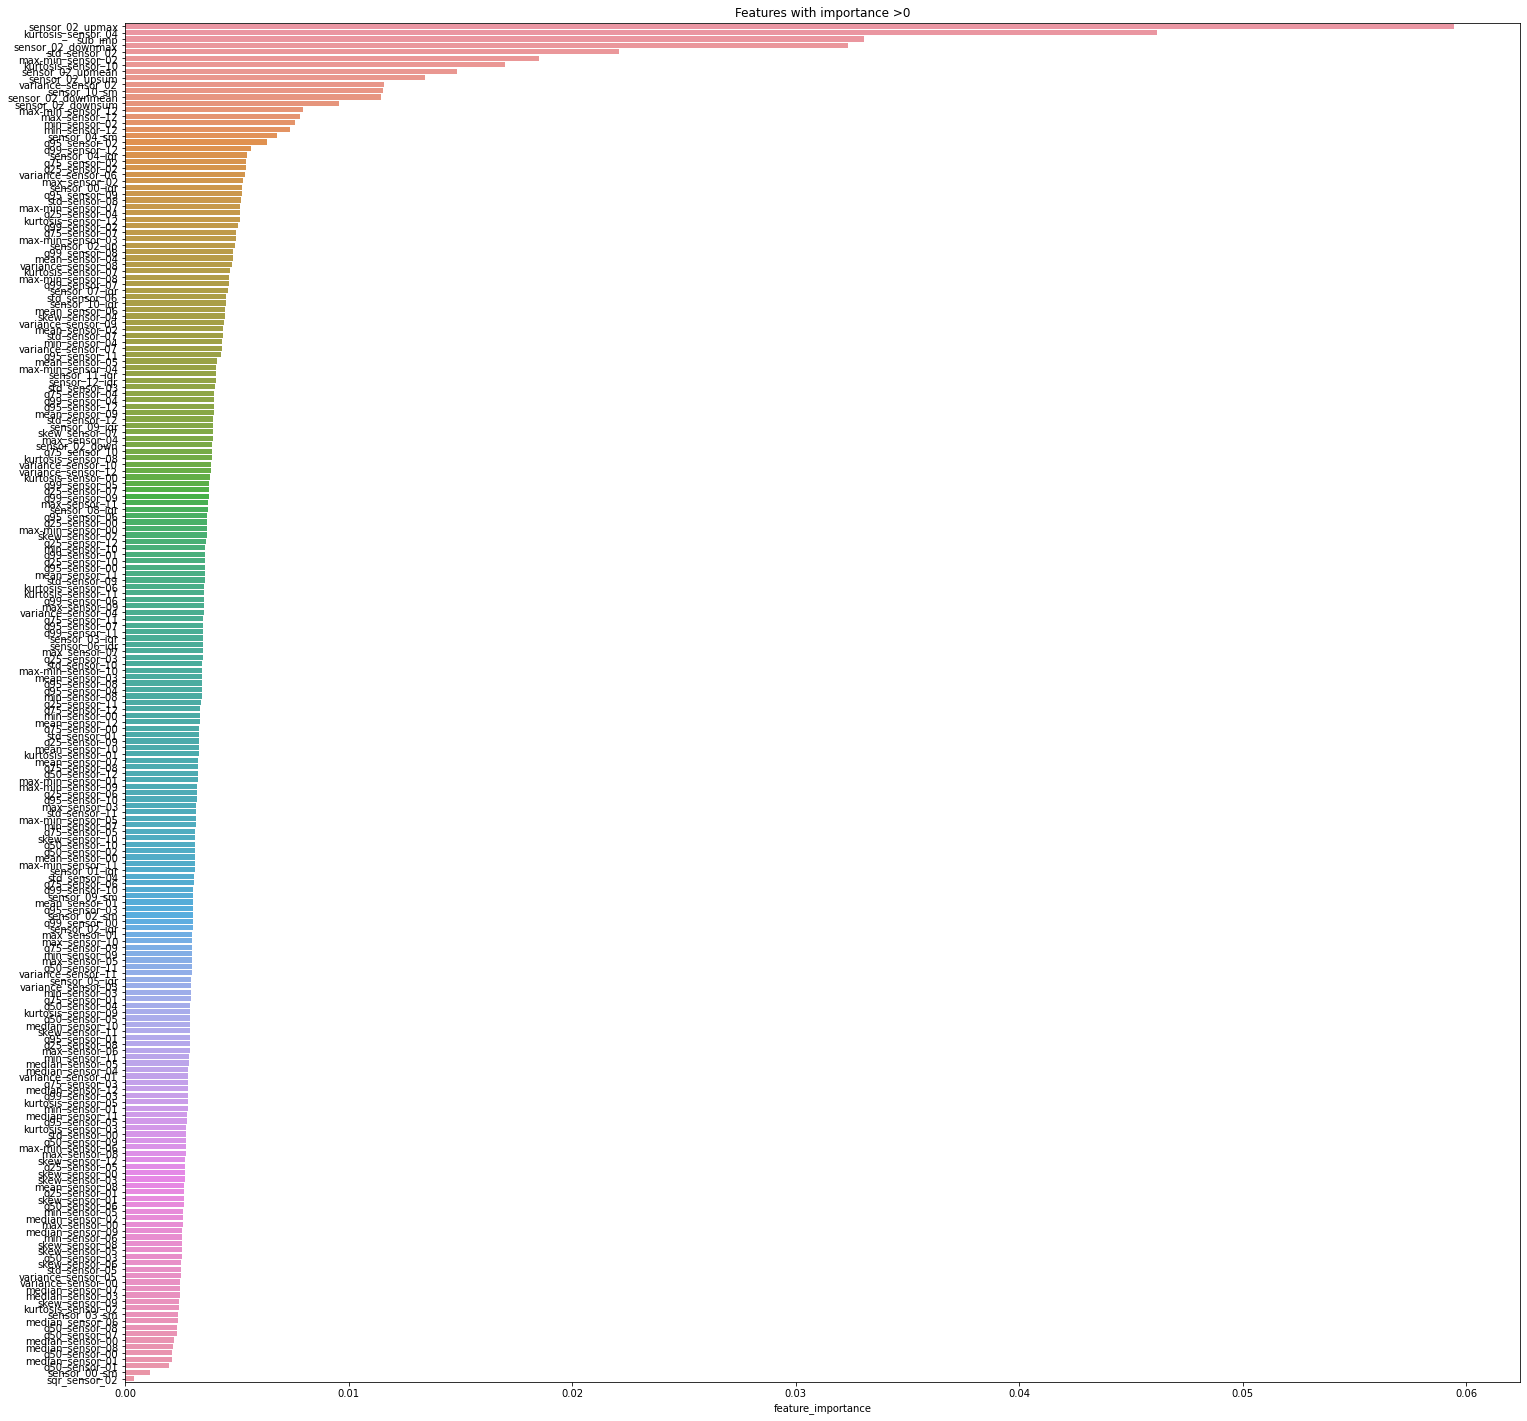

In [20]:
feat_importance = pd.DataFrame(data = xgb.feature_importances_,index = train.drop("state",axis =1).columns, columns = ["feature_importance"]).sort_values(by=['feature_importance'], ascending=False)

plt.figure(figsize=(25,25))
sns.barplot(x=feat_importance[feat_importance['feature_importance']>0]['feature_importance'], y=feat_importance[feat_importance['feature_importance']>0].index)
plt.title("Features with importance >0")
plt.show()

In [21]:
print("FEATURES with 0 importance\n")
print([col for col in feat_importance[feat_importance['feature_importance']==0].index])

FEATURES with 0 importance

[]


# Calibration plot & recalibration
https://wttech.blog/blog/2021/a-guide-to-model-calibration/

In [22]:
prob_true, prob_pred = calibration_curve(y_test, val_preds[:,1], n_bins=10)

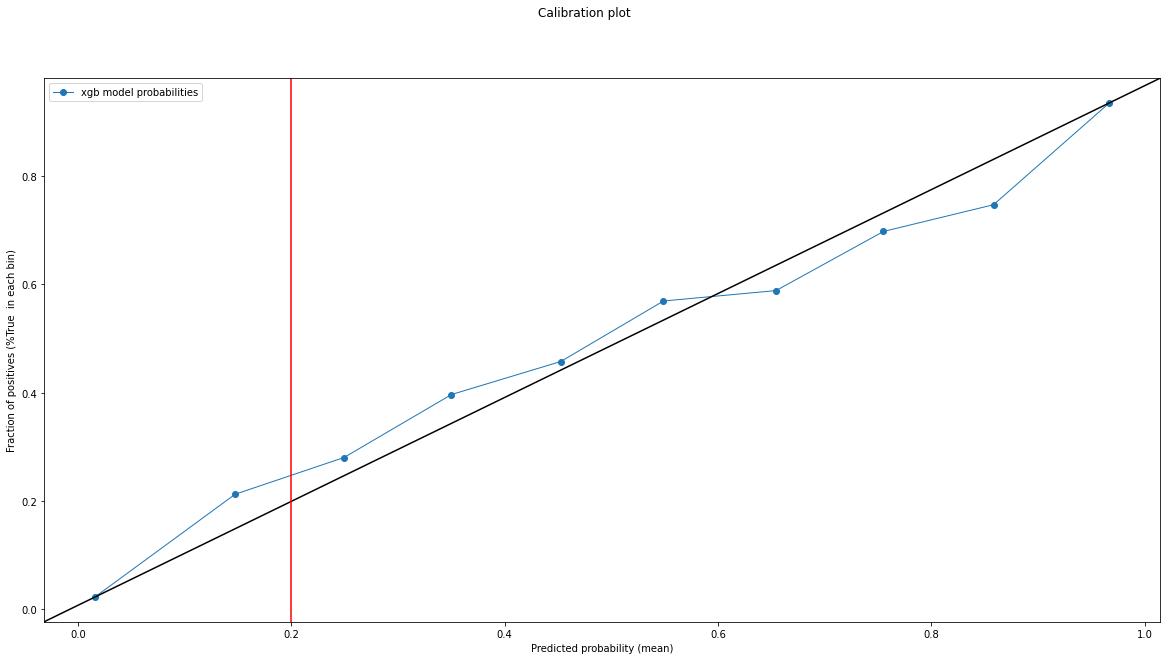

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(prob_pred,prob_true, marker='o', linewidth=1, label='xgb model probabilities')

# reference line
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.axvline(x=0.2, color = "r")
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability (mean)')
ax.set_ylabel('Fraction of positives (%True  in each bin)')
plt.legend()
plt.show()

#### Notes on graph:
We have a S-shaped calibration plot

This showcases that we are:
* **Underpredicting** where the fraction of True positive values is **higher** 
* **Over predicting** where the fraction of True positive values is **lower**

i.e. if we have 20% of postive values in our data (in otherwords 20% Accuracy) we should predict 20% postive values
However (from the red line graph) we are predicting around under 30% probability  --> Overpredicting

Calibration tries to fix this by "shifting" the values using calibration methods such as:
* isotonic 
* sigmoid (Platts method) 

In [24]:
calibrator = CalibratedClassifierCV(xgb, method = "isotonic", cv='prefit')
calibrator.fit(X_test, y_test)
cal_preds = calibrator.predict_proba(X_test)

print("Validation AUC:" , roc_auc_score(y_test, val_preds[:, 1] ))
print("calibrated AUC:" , roc_auc_score(y_test, cal_preds[:, 1] ))

Validation AUC: 0.9454637136198163
calibrated AUC: 0.9465126489921262


# Cross Validation

In [25]:
del xgb
del X_train
del y_train
del X_test
del y_test
del val_preds
del train_preds
del calibrator

gc.collect()

49299

In [26]:
X = train.drop("state",axis =1)
y = train["state"]

In [27]:
kfold = GroupKFold(n_splits = FOLDS)

In [28]:
auc_cv = []
preds = []

for fold, (train_idx, val_idx) in enumerate (kfold.split(X,y, groups =train_original.sequence)):

    print("\n","#"*10, f"Fold {fold+1}","#"*10)
    X_train, X_test = X.iloc[train_idx] , X.iloc[val_idx]
    y_train , y_test = y.iloc[train_idx], y.iloc[val_idx]
   
    ### SCALING ----ADDDD 
    if SCALING:
        print("scaling")
        scaler= StandardScaler()
        X_train = scaler.fit_transform(X_train) 
        X_test = scaler.transform(X_test)
        test_s = scaler.transform(test)
    else:
        test_s = test.copy()
    
    model = XGBClassifier(**params,use_label_encoder=False)
    model.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = ['auc'], early_stopping_rounds = 128, verbose = 50)
    
    if CALIBRATION:
        calibrator = CalibratedClassifierCV(model, method = "isotonic", cv='prefit')
        calibrator.fit(X_test, y_test)
        auc = roc_auc_score(y_test, calibrator.predict_proba(X_test)[:, 1])
        print("\n Calibration AUC:" , auc)
        preds.append(calibrator.predict_proba(test_s)[:, 1])
    else:
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print("\n Validation AUC:" , auc)
        preds.append(model.predict_proba(test_s)[:, 1])

    auc_cv.append(auc)

    del X_train
    del X_test
    del y_train
    del y_test
    del model
    #del calibrator
    
    gc.collect()

print("FINAL AUC: ", np.mean(auc_cv))


 ########## Fold 1 ##########
scaling
[0]	validation_0-auc:0.84090
[50]	validation_0-auc:0.91297
[100]	validation_0-auc:0.91688
[150]	validation_0-auc:0.92034
[200]	validation_0-auc:0.92401
[250]	validation_0-auc:0.92647
[300]	validation_0-auc:0.92817
[350]	validation_0-auc:0.92931
[400]	validation_0-auc:0.93053
[450]	validation_0-auc:0.93138
[500]	validation_0-auc:0.93195
[550]	validation_0-auc:0.93251
[600]	validation_0-auc:0.93325
[650]	validation_0-auc:0.93355
[700]	validation_0-auc:0.93391
[750]	validation_0-auc:0.93415
[800]	validation_0-auc:0.93441
[850]	validation_0-auc:0.93464
[900]	validation_0-auc:0.93476
[950]	validation_0-auc:0.93482
[1000]	validation_0-auc:0.93502
[1050]	validation_0-auc:0.93533
[1100]	validation_0-auc:0.93543
[1150]	validation_0-auc:0.93561
[1200]	validation_0-auc:0.93579
[1250]	validation_0-auc:0.93580
[1300]	validation_0-auc:0.93591
[1350]	validation_0-auc:0.93613
[1400]	validation_0-auc:0.93620
[1450]	validation_0-auc:0.93644
[1500]	validation_0-auc:

# Submission

In [29]:
test_original = pd.read_csv("../input/tabular-playground-series-apr-2022/test.csv")

final_preds = np.sum(preds,axis =0)/FOLDS
test_original["state"] = final_preds
sub["state"] = test_original.groupby(["sequence", "subject"]).mean()["state"].values
sub.to_csv("submission.csv")
sub

,state
sequence,
25968,0.662585
25969,0.965875
25970,0.000000
25971,0.542455
25972,0.676010
...,...
38181,0.943281
38182,0.846059
38183,0.595820


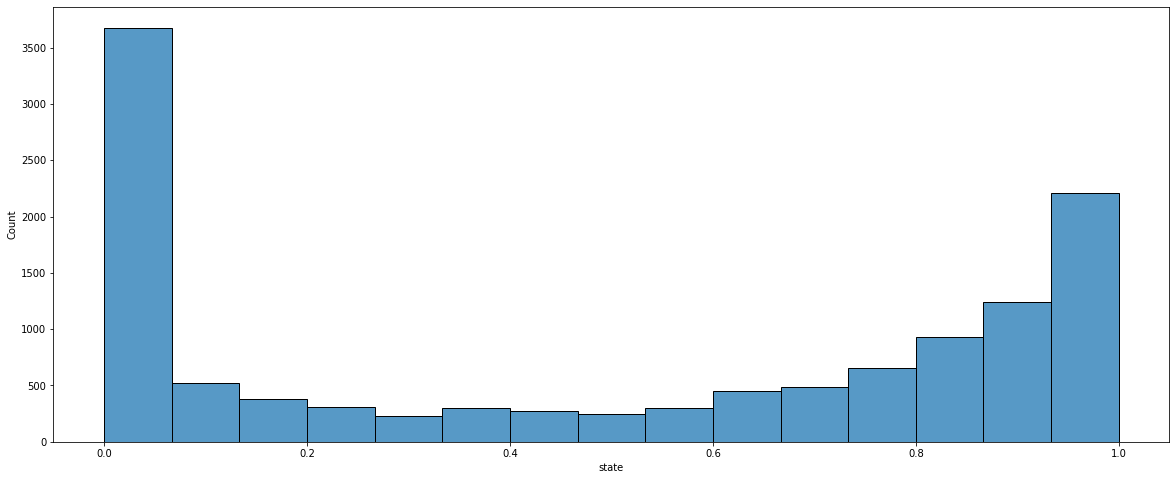

In [30]:
plt.figure(figsize = (20,8))
sns.histplot(sub["state"])
plt.show()